### This script uses a nonlinear least squares solver to find optimal model parameters

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import least_squares

#### Same model as in part 5, but CD0 and CLa are stored in single variable 'pararms' and output is the error sum of squares

In [2]:
def model_trajectory_full_model(params,data,sampleRate,S,m,omega,plot):

    # CD0 and CLa
    CD0=params[0]
    CLa=params[1]
    
    # format data
    sx = data[:,0];
    sy = data[:,1];
    vx = data[:,2];
    vy = data[:,3];
    
    v0vert=vy[0]
    v0horz=vx[0]
    h0=sy[0]
    theta0=np.degrees(np.arctan(vy[0]/vx[0]))
    
    # get time series
    t=np.arange(0, len(sx)/sampleRate,1/sampleRate)

    # fixed parameters
    rho = 1.225; # air density
    g = 9.81 # acceleration due to gravity
    
    vy = v0vert
    vx = v0horz
    theta = theta0
    
    shorz=np.array([0])
    svert=np.array([h0])
        
    t_step = 1/sampleRate # time step
    
    # lift and drag coefficients taking into account spin
    CL=(-CLa*np.exp(-0.25*np.absolute(omega))+CLa)*np.sign(omega);
    CD=CD0+0.005*np.absolute(omega);

    cont=1
    
    while cont==1:
        
        vtot=np.hypot(vx,vy) # total velocity

        ax=-0.5*1/m*rho*vtot*S*(vx*CD+vy*CL); # horizontal acceleration
        ay=-0.5*1/m*rho*vtot*S*(vy*CD-vx*CL)-g; # vertical acceleration
    
        # update variables
        vx=vx + ax*t_step; # horizontal velocity
        vy=vy + ay*t_step; # vertical velocity
        
        shorznew=shorz[-1] + vx*t_step + 0.5*ax*np.square(t_step);
        svertnew=svert[-1] + vy*t_step + 0.5*ay*np.square(t_step);
        
        if len(shorz)>=len(sx):
            cont=0
        else:
            shorz = np.append(shorz,shorznew)
            svert = np.append(svert,svertnew)
            
    error=np.sum(np.square(svert-sy)+np.square(shorz-sx))
    
    if plot==1:
        fig, ax = plt.subplots(figsize=(10,5))
        ax.plot(sx,sy,label='Data');
        ax.plot(shorz,svert,label='Model');
        ax.axis('scaled')
        ax.set_xlabel('x (m)');
        ax.set_ylabel('y (m)');
        ax.legend();
        
    return error

#### Fix values

In [3]:
S = 0.00125 # fixed, based on a standard 40mm diameter ball
m = 0.0027 # fixed, based on a standard 2.7g ball
sampleRate=250

#### Use least_squares function to find opimtimal values of CD0 and CLa

Optimal CD0 = 0.36944138940467164
Optimal CLa = 0.15867500033357573


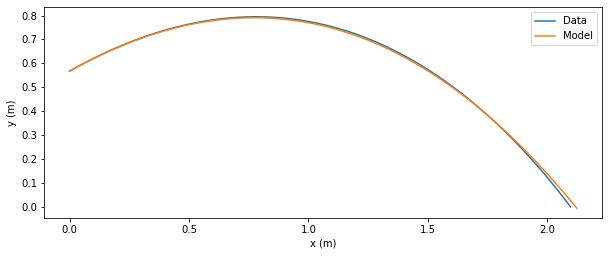

In [4]:
trajectory=70
%matplotlib inline
data = np.genfromtxt('trajectories/trajectory'+str(trajectory)+'.txt',delimiter=',');

spinrates = np.genfromtxt('spinrates.txt',delimiter=',');
omega=spinrates[trajectory-1]

params0=[0.5,0.5] # initial values for CD0 and CLa
res_lsq = least_squares(model_trajectory_full_model, params0, args=(data, sampleRate, S, m, omega,0))

CD0_opt=res_lsq.x[0]
CLa_opt=res_lsq.x[1]

model_trajectory_full_model([CD0_opt, CLa_opt],data,sampleRate,S,m,omega,1);
print('Optimal CD0 =',CD0_opt)
print('Optimal CLa =',CLa_opt)

#### Would be better to find an overall optimum for all sequences
First load in all the data and store in a single array to save time loading text files each time

In [5]:
data_array=[]

for trajectory in np.arange(1,83):
    data = np.genfromtxt('trajectories/trajectory'+str(trajectory)+'.txt',delimiter=',')
    data_array.append(data)


#### Can now create a new function that runs on all the data simultaneously

In [6]:
def model_all_trajectories(params,data_array,sampleRate,S,m,spinrates):

    # CD0 and CLa
    CD0=params[0]
    CLa=params[1]
    
    error=[]
    for i in np.arange(0,len(data_array)):
        
        data=data_array[i];
        omega=spinrates[i]

        # format data
        sx = data[:,0];
        sy = data[:,1];
        vx = data[:,2];
        vy = data[:,3];

        v0vert=vy[0]
        v0horz=vx[0]
        h0=sy[0]
        theta0=np.degrees(np.arctan(vy[0]/vx[0]))

        # get time series
        t=np.arange(0, len(sx)/sampleRate,1/sampleRate)

        # fixed parameters
        rho = 1.225; # air density
        g = 9.81 # acceleration due to gravity

        vy = v0vert
        vx = v0horz
        theta = theta0

        shorz=np.array([0])
        svert=np.array([h0])

        t_step = 1/sampleRate # time step

        # lift and drag coefficients taking into account spin
        CL=(-CLa*np.exp(-0.25*np.absolute(omega))+CLa)*np.sign(omega);
        CD=CD0+0.005*np.absolute(omega);

        cont=1
        
        while cont==1:

            vtot=np.hypot(vx,vy) # total velocity

            ax=-0.5*1/m*rho*vtot*S*(vx*CD+vy*CL); # horizontal acceleration
            ay=-0.5*1/m*rho*vtot*S*(vy*CD-vx*CL)-g; # vertical acceleration

            # update variables
            vx=vx + ax*t_step; # horizontal velocity
            vy=vy + ay*t_step; # vertical velocity

            shorznew=shorz[-1] + vx*t_step + 0.5*ax*np.square(t_step);
            svertnew=svert[-1] + vy*t_step + 0.5*ay*np.square(t_step);

            if len(shorz)>=len(sx):
                cont=0
            else:
                shorz = np.append(shorz,shorznew)
                svert = np.append(svert,svertnew)

        error.append(np.sum(np.square(svert-sy)+np.square(shorz-sx)))
        
#     print(error)
    error_total=np.sum(error)
    
    return error_total

#### Now run least squares solver on all trajectories simultaneously

In [7]:
params0=[0.5,0.5] # initial values for CD0 and CLa
res_lsq = least_squares(model_all_trajectories, params0, args=(data_array, sampleRate, S, m, spinrates))

CD0_globalopt=res_lsq.x[0]
CLa_globalopt=res_lsq.x[1]

print('Optimal CD0 =',CD0_globalopt)
print('Optimal CLa =',CLa_globalopt)

Optimal CD0 = 0.31227414337034753
Optimal CLa = 0.2611257377962841


#### Test results on a single sequence

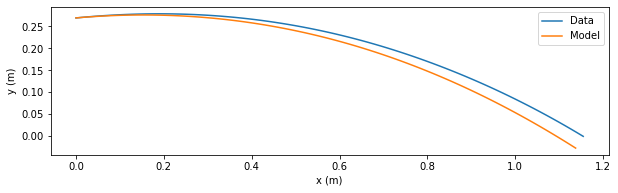

In [9]:
trajectory=40

omega=spinrates[trajectory-1]
model_trajectory_full_model([CD0_globalopt, CLa_globalopt],data_array[trajectory-1],sampleRate,S,m,omega,1);
